# Question 1 : NLM

In [2]:
from skimage.metrics import mean_squared_error,peak_signal_noise_ratio
import matplotlib.pyplot as plt
from PIL import Image,ImageOps
import numpy as np
import math
from tabulate import tabulate
from numba import njit,prange

## Loading images and adding Gaussian noise 

In [3]:

image1=Image.open('Dataset/NLM/image1.png')
img1=ImageOps.grayscale(image1)
image2=Image.open('Dataset/NLM/image2.png')
img2=ImageOps.grayscale(image2)
image3=Image.open('Dataset/NLM/image3.png')
img3=ImageOps.grayscale(image3)
image4=Image.open('Dataset/NLM/input4.png')
img4=ImageOps.grayscale(image4)


imgs=[np.array(img1),np.array(img2),np.array(img3),np.array(img4)]

stdv=[15,45,80]
noisy_images=[]

for index in range(0,4):
  imgs[index].astype(float)
  for i in range(0,3):
    gausian=np.random.normal(0,stdv[i],(imgs[index].shape))
    noisy_image=np.clip(imgs[index]+gausian,0,255)
    noisy_images.append((Image.fromarray(np.uint8(noisy_image))))



## NLM algorithm implementation

In [4]:
@njit
def compute_euclidian_distance(p_cw,q_cw,f):
  d=(1/((2*f+1)**2))
  sum=0
  for i in prange(p_cw.shape[0]):
    for j in prange(p_cw.shape[1]):
       value=(p_cw[i][j]-q_cw[i][j])**2
       sum+=value
  return d*sum

@njit
def compute_weight(q_cw,p_cw,f,stdv,h):
  value=max(compute_euclidian_distance(p_cw,q_cw,f)-2*stdv**2,0)
  value=(-1/h**2)*(value)
  w=math.exp(value)
  return w

@njit
def compute_C(original_image,istart,iend,jstart,jend,p_cw,f,stdv,h):
   c=0
   for i in prange(istart,iend):
     for j in prange(jstart,jend):
        c+=compute_weight(original_image[i-f:i+f+1,j-f:j+f+1],p_cw,f,stdv,h)
   return c


@njit
def compute_RW(original_image,istart,iend,jstart,jend,image_p,f,stdv,h):
   sum=0
   for i in prange(istart,iend):
     for j in prange(jstart,jend):
          value=original_image[i][j]*compute_weight(original_image[i-f:i+f+1,j-f:j+f+1],image_p,f,stdv,h)
          sum+=value
   return sum
   


@njit(parallel=True)
def denoise_image(image,h,r,f,stdv):
  generated_image=np.zeros((image.shape))
  for i in prange(r+f,image.shape[0]-(r+f)):
     for j in prange(r+f,image.shape[1]-(r+f)):
          generated_image[i][j]=((1/compute_C(image,i-r,i+r+1,j-r,j+r+1,image[i-f:i+f+1,j-f:j+f+1],f,stdv,h))*compute_RW(image,i-r,i+r+1,j-r,j+r+1,image[i-f:i+f+1,j-f:j+f+1],f,stdv,h))

  return generated_image



denoised_images=[]
optimal_images=[0]*12
optimal_h=[0]*12
optimal_f=[0]*12
optimal_rmse=[0]*12
optimal_psnr=[0]*12

for i in range(len(noisy_images)):
    RMSE=1e9
    PSNR=0
    for k in np.linspace(0.01,0.65,9):
      for f in [1,2,3,4]:
          k=round(k,2)
          h=k*stdv[i%3]
          if(stdv[i%3]<=45):
            r=10
          else:
            r=17 
          padded_image=np.pad(noisy_images[i],pad_width=r+f)
          denoised_image=denoise_image(padded_image,h,r,f,stdv[i%3])
          denoised_image=denoised_image[r+f:denoised_image.shape[0]-(r+f),r+f:denoised_image.shape[1]-(r+f)]
          current_RMSE=np.sqrt(mean_squared_error(imgs[i//3].astype(np.float64),denoised_image))
          current_PSNR=peak_signal_noise_ratio(imgs[i//3].astype(np.float64),denoised_image,data_range=imgs[i//3].max()-imgs[i//3].min())
          print('RMSE : {:.2f} | PSNR : {:.2f}'.format(current_RMSE,current_PSNR))
          if(current_RMSE<RMSE and current_PSNR>PSNR):
            RMSE=current_RMSE
            PSNR=current_PSNR
            optimal_h[i]=h
            optimal_f[i]=f
            optimal_images[i]=denoised_image
          denoised_images.append(denoised_image)
    optimal_rmse[i]=RMSE
    optimal_psnr[i]=PSNR
    

RMSE : 8.65 | PSNR : 29.25
RMSE : 9.54 | PSNR : 28.40
RMSE : 10.48 | PSNR : 27.59
RMSE : 11.20 | PSNR : 27.01
RMSE : 8.64 | PSNR : 29.27
RMSE : 9.51 | PSNR : 28.43
RMSE : 10.42 | PSNR : 27.63
RMSE : 11.14 | PSNR : 27.06
RMSE : 8.60 | PSNR : 29.30
RMSE : 9.42 | PSNR : 28.52
RMSE : 10.28 | PSNR : 27.75
RMSE : 10.95 | PSNR : 27.20
RMSE : 8.54 | PSNR : 29.36
RMSE : 9.27 | PSNR : 28.66
RMSE : 10.05 | PSNR : 27.95
RMSE : 10.63 | PSNR : 27.46
RMSE : 8.46 | PSNR : 29.45
RMSE : 9.06 | PSNR : 28.85
RMSE : 9.72 | PSNR : 28.24
RMSE : 10.19 | PSNR : 27.83
RMSE : 8.37 | PSNR : 29.54
RMSE : 8.82 | PSNR : 29.08
RMSE : 9.34 | PSNR : 28.58
RMSE : 9.70 | PSNR : 28.26
RMSE : 8.28 | PSNR : 29.64
RMSE : 8.60 | PSNR : 29.30
RMSE : 8.99 | PSNR : 28.92
RMSE : 9.28 | PSNR : 28.65
RMSE : 8.20 | PSNR : 29.72
RMSE : 8.44 | PSNR : 29.47
RMSE : 8.75 | PSNR : 29.15
RMSE : 8.99 | PSNR : 28.92
RMSE : 8.15 | PSNR : 29.77
RMSE : 8.37 | PSNR : 29.53
RMSE : 8.67 | PSNR : 29.24
RMSE : 8.88 | PSNR : 29.02
RMSE : 17.28 | PSNR

## Ploting images

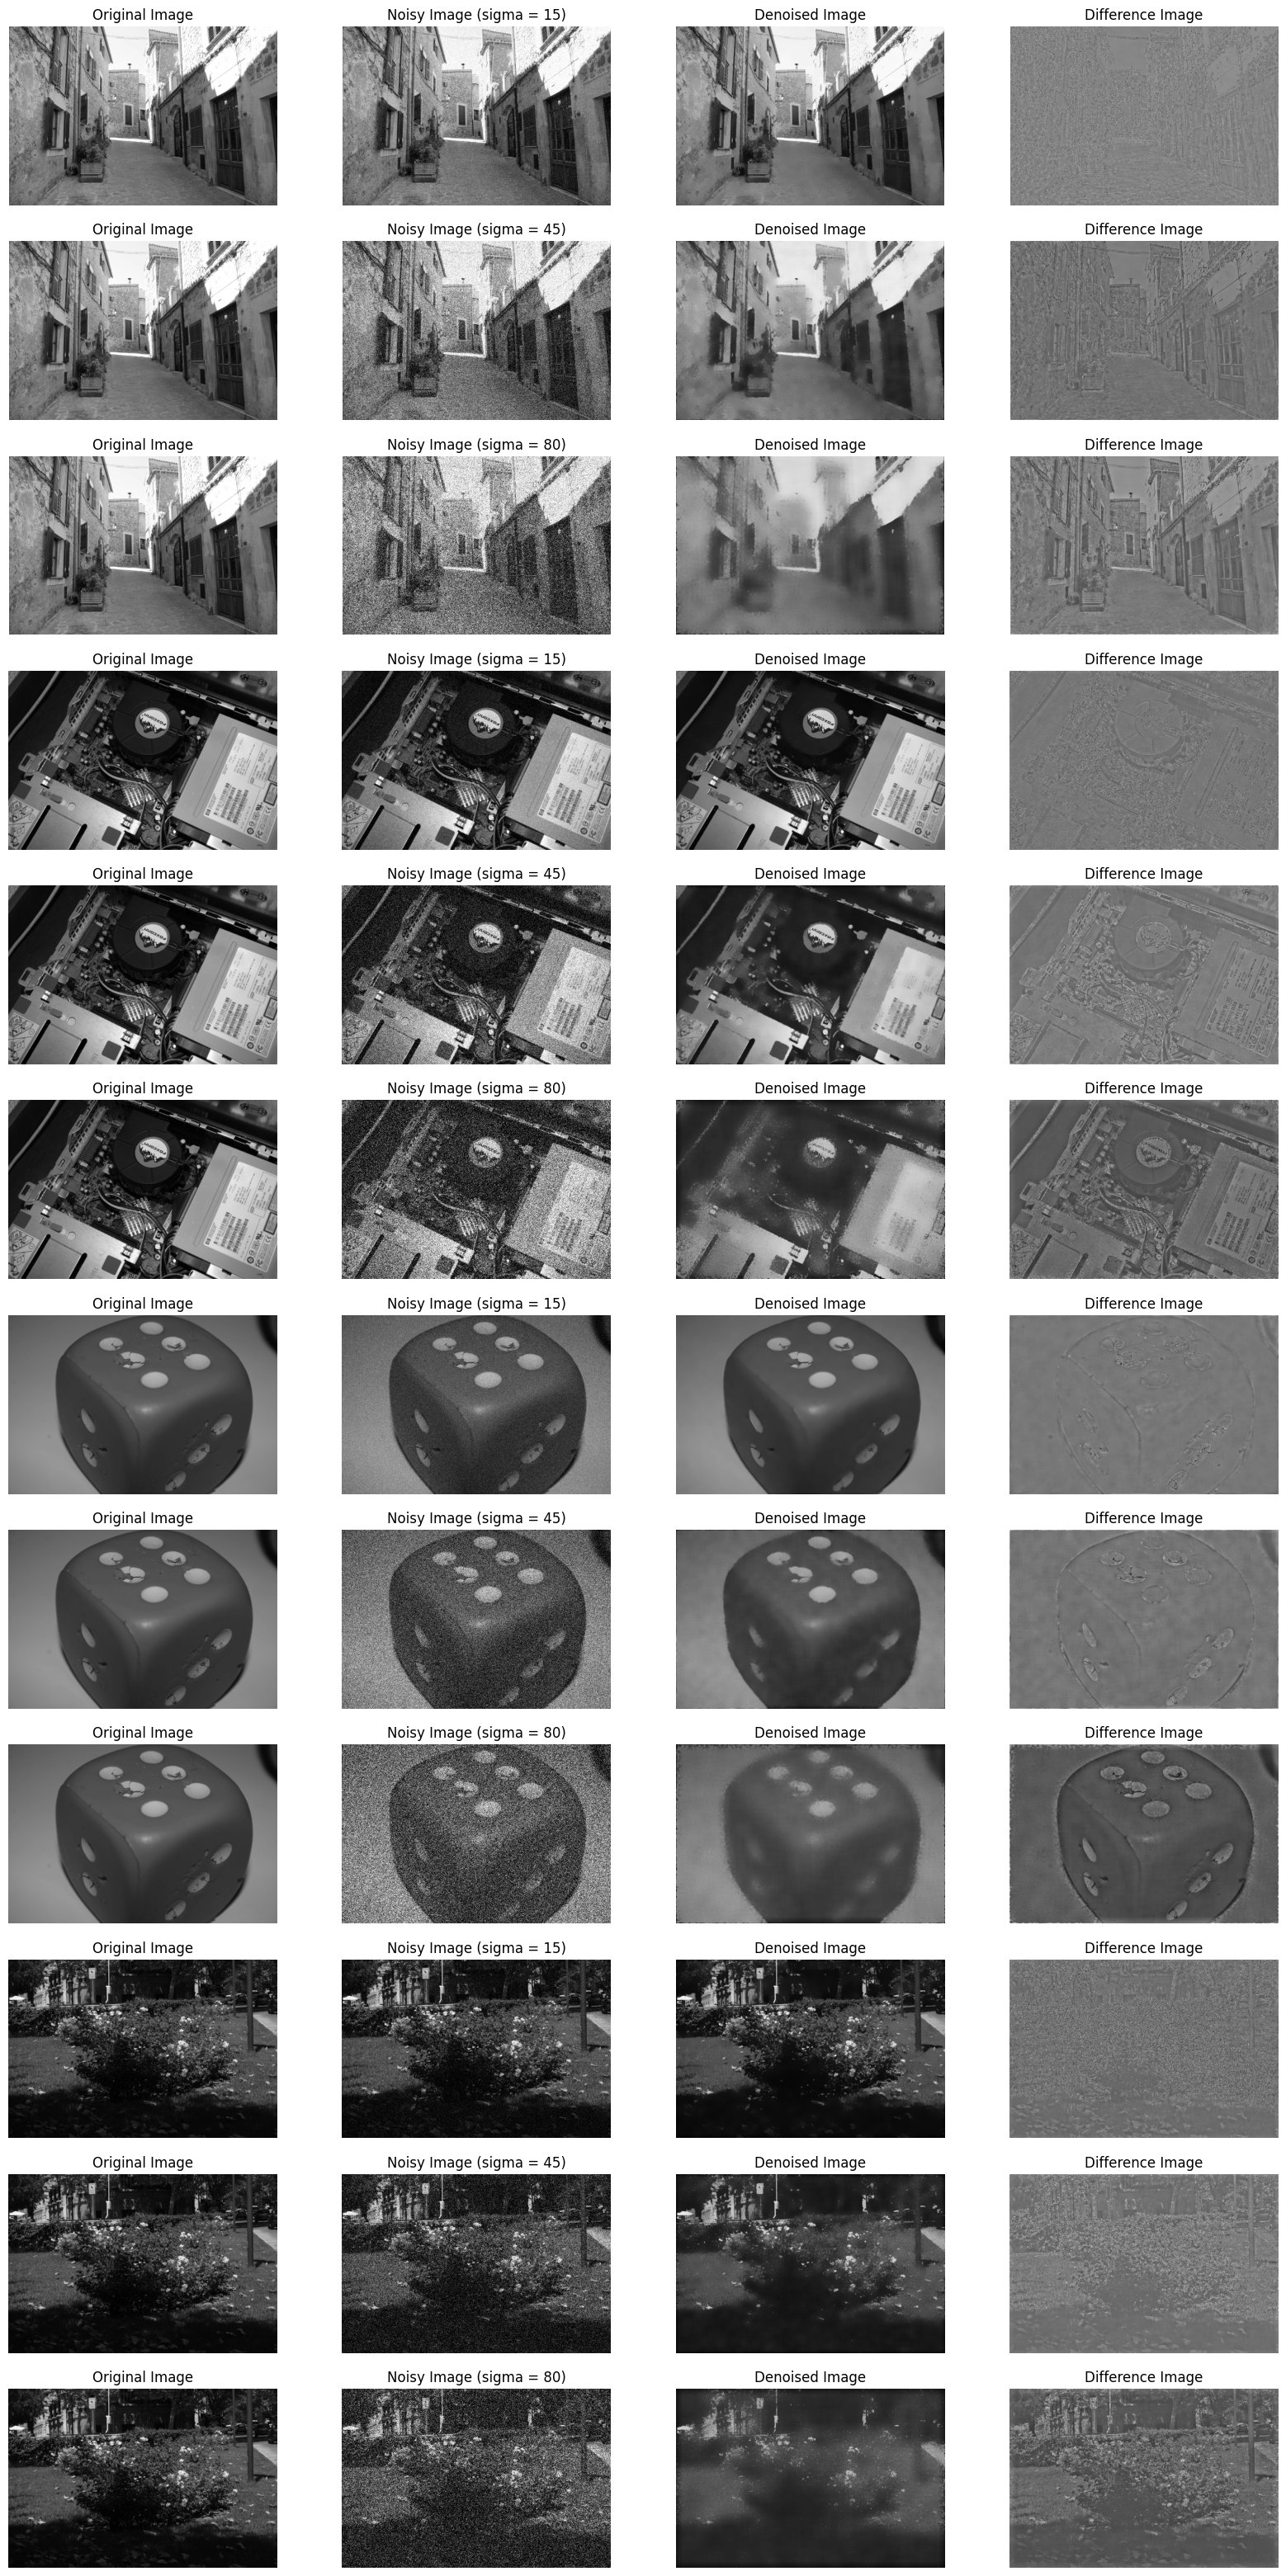

In [5]:
# original image,noisy image, denoised image, difference image

fig=plt.figure(figsize=(20,40))

index=0
for i in range(12):
    index+=1
    fig.add_subplot(12,4,index)
    plt.imshow(imgs[i//3],cmap='gray',vmin=0,vmax=255)
    plt.title('Original Image')
    plt.axis('off') 
    
    index+=1
    fig.add_subplot(12,4,index)
    plt.imshow(noisy_images[i],cmap='gray',vmin=0,vmax=255)
    plt.title(f'Noisy Image (sigma = {stdv[i%3]})')
    plt.axis('off')

    index+=1
    fig.add_subplot(12,4,index)
    plt.imshow(optimal_images[i],cmap='gray',vmin=0,vmax=255)
    plt.title('Denoised Image')
    plt.axis('off')

    index+=1
    fig.add_subplot(12,4,index)
    plt.imshow(imgs[i//3].astype(float)-optimal_images[i].astype(float),cmap='gray')
    plt.title('Difference Image')
    plt.axis('off')

## Results 

In [6]:
image_no=[]
optimal_2fplus1=[]
sigmas=[]
for i in range(12):
    image_no.append(i//3+1)
    optimal_2fplus1.append((optimal_f[i]*2)+1)
    sigmas.append(stdv[i%3])
optimal_2fplus1=np.transpose(optimal_2fplus1)

results=[image_no,sigmas,optimal_h,optimal_2fplus1,optimal_rmse,optimal_psnr]
results=np.transpose(results)
title=["Image Number","Sigma","Optimal h","Optimal (2f+1)","RMSE","PSNR"]
print(tabulate(results,headers=title,tablefmt="grid"))


+----------------+---------+-------------+------------------+----------+---------+
|   Image Number |   Sigma |   Optimal h |   Optimal (2f+1) |     RMSE |    PSNR |
+================+=========+=============+==================+==========+=========+
|              1 |      15 |        9.75 |                3 |  8.15067 | 29.7696 |
+----------------+---------+-------------+------------------+----------+---------+
|              1 |      45 |       18.45 |                5 | 16.1121  | 23.8504 |
+----------------+---------+-------------+------------------+----------+---------+
|              1 |      80 |        0.8  |                5 | 24.9884  | 20.0387 |
+----------------+---------+-------------+------------------+----------+---------+
|              2 |      15 |        9.75 |                3 |  6.88063 | 31.2409 |
+----------------+---------+-------------+------------------+----------+---------+
|              2 |      45 |       18.45 |                5 | 15.5056  | 24.1837 |
+---

## Observations


- As the value of sigma (standard deviation) increases, the RMSE increases because we are adding more noise in the image subsequently, and therefore, denoising of the image makes the image more blurry. So, as the image becomes more blurred, the RMSE is going to be more.
- As we can see from the results, most of the optimal values of the comparison window (2f+1) are lower values because the weight matrix will calculate the weight of near neighbors; hence, it will be more localized.
- The denoised image of higher sigma values becomes blurred because now the weight of most of the pixels in the research window will be similar, and hence, the final pixel value in the denoised image will be the weighted average of all its neighboring pixels in the research window; therefore it will become more blur.
- As we can see from the results, the optimal value of h for very noisy images (sigma = 80) is 0.8, so it has taken k=0.01, the smallest out of all k values. Here, as the value of h is small, the weight calculated for each pixel in the research window will be less, because of which the resultant image will be less blurred compared to higher values of h. hence, it is choosing less value of k here.

# Question 2 : Histogram Matching

In [7]:
import matplotlib.pyplot as plt
from PIL import Image,ImageOps
import numpy as np

## Loading images

In [8]:
grey1=np.array(ImageOps.grayscale(Image.open('Dataset/histogram_matching/grey_1.png')))
grey2=np.array(ImageOps.grayscale(Image.open('Dataset/histogram_matching/grey_2.png')))
grey3=np.array(ImageOps.grayscale(Image.open('Dataset/histogram_matching/grey_3.png')))
grey4=np.array(ImageOps.grayscale(Image.open('Dataset/histogram_matching/grey_4.png')))

pairs=[[grey1,grey2],[grey4,grey3],[grey2,grey4],[grey3,grey1]]


## Histogram matching implementation

In [9]:

def histogram_matching(source_image,source_hist,target_hist):
    for i in range(source_image.shape[0]):
        for j in range(source_image.shape[1]):
            p_value=source_image[i][j]
            s_value=source_hist[int(p_value)]
            t_value=np.argmin(abs(target_hist-s_value))
            source_image[i][j]=t_value
    return source_image



def compute_equalized_histogram(eq_source_hist,eq_target_hist,source_hist,target_hist):
    eq_source_hist[0]=source_hist[0]
    eq_target_hist[0]=target_hist[0]
    for i in range(1,256):
        eq_source_hist[i]=eq_source_hist[i-1]+source_hist[i]
        eq_target_hist[i]=eq_target_hist[i-1]+target_hist[i]
    return eq_source_hist,eq_target_hist



def compute_histogram(source_image,target_image,source_hist,target_hist):
    for i in range(source_image.shape[0]):
        for j in range(source_image.shape[1]):
            source_hist[int(source_image[i][j])]+=1

    for i in range(target_image.shape[0]):
        for j in range(target_image.shape[1]):
            target_hist[int(target_image[i][j])]+=1

    source_hist/=total_pixels
    target_hist/=total_pixels
    
    return source_hist,target_hist

    
    
total_pixels=grey1.shape[0]*grey1.shape[1]
mapped_images=[]
for pair in pairs:
    source_hist=np.zeros(256)
    target_hist=np.zeros(256)
    eq_source_hist=np.zeros(256)
    eq_target_hist=np.zeros(256)
    s_image=pair[0].copy()
    source_hist,target_hist=compute_histogram(pair[0],pair[1],source_hist,target_hist)
    eq_source_hist,eq_target_hist=compute_equalized_histogram(eq_source_hist,eq_target_hist,source_hist,target_hist)
    generated_image=histogram_matching(s_image,eq_source_hist,eq_target_hist)
    mapped_images.append(generated_image)


## Ploting results

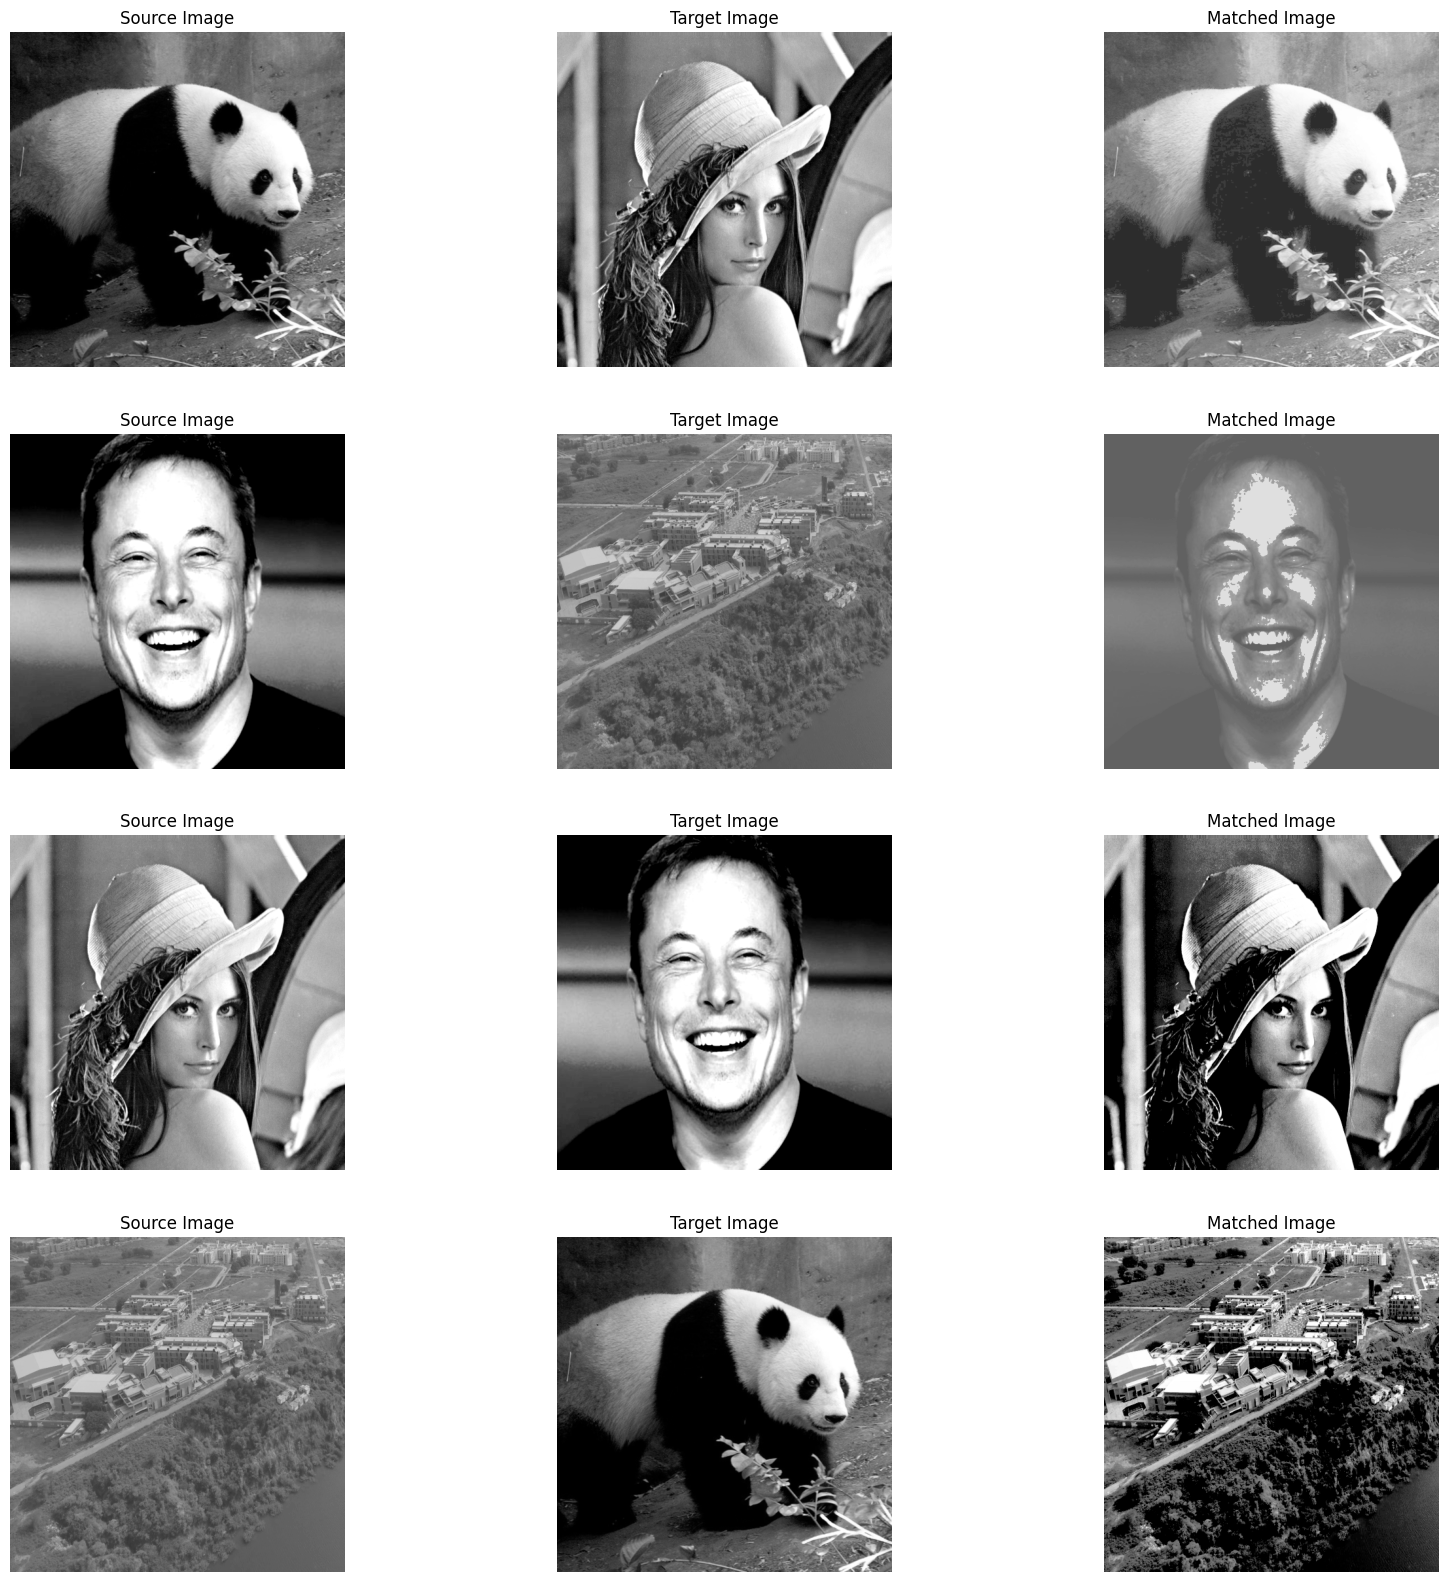

In [10]:
fig=plt.figure(figsize=(20,20))
count=1
for i in range(4):
    fig.add_subplot(4,3,count)
    plt.imshow(pairs[i][0],cmap='gray',vmin=0,vmax=255)
    plt.title('Source Image')
    count+=1
    plt.axis('off')
    fig.add_subplot(4,3,count)
    plt.imshow(pairs[i][1],cmap='gray',vmin=0,vmax=255)
    plt.title('Target Image')
    count+=1
    plt.axis('off')
    fig.add_subplot(4,3,count)
    plt.imshow(mapped_images[i],cmap='gray',vmin=0,vmax=255)
    plt.title('Matched Image')
    count+=1
    plt.axis('off')


## Observations 


- As we can see from the images, after matching the histograms of two images, the matched image has pixel intensity values similar to the pixel intensity values of the target image; therefore, we can say that our algorithm is working fine.
- For example, if we observe the last pair of images, the source image has pixel intensity values such that its histogram will be on the right side, and for the target, it will be on the left side, but after matching, the histogram of new image will be on the left side as it will be taking values from the target image. 
- The converted source image now has a histogram shifted towards the left side.


## References


- https://datagy.io/numpy-pad/
- https://www.tutorialspoint.com/python3/number_exp.htm
- https://stackoverflow.com/questions/54259656/how-can-i-select-a-small-matrix-from-a-larger-matrix-by-its-index
- https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
- https://www.sitepoint.com/python-multiprocessing-parallel-programming/#:~:text=One%20way%20to%20achieve%20parallelism,multiprocessing%20accomplishes%20process%2Dbased%20parallelism.
- https://stackoverflow.com/questions/69828100/how-to-parallelise-using-jit-numba-parallel
- https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error
- https://www.geeksforgeeks.org/how-to-make-a-table-in-python/
